##Process dataset 1

In [ ]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
from collections import OrderedDict
from typing import List, Tuple
# from torchsummary import summary
# from torch.utils.tensorboard import SummaryWriter

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchsummary import summary
from typing import Callable, Dict, List, Optional, Tuple
# from flwr.server.history import History
from torch.optim import lr_scheduler
from pathlib import Path
# import flwr as fl
# from flwr.common import Metrics
# from flwr.common.typing import NDArrays, Scalar
import json

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU

from tqdm import tqdm

In [ ]:
!gdown https://drive.google.com/uc?id=1Sg1QhTnlkFNRy6p_5t2rQN9ljD6OdRm0

Downloading...
From: https://drive.google.com/uc?id=1Sg1QhTnlkFNRy6p_5t2rQN9ljD6OdRm0
To: /content/b_cancer_data2.zip
100% 4.28G/4.28G [01:03<00:00, 67.4MB/s]


In [ ]:
!pip install Pillow
!pip install gdown
# !pip install tensorboard

In [ ]:
!rm -rf b_cancer_data2 b_cancer_data || true
!unzip -qq b_cancer_data2.zip
!mv b_cancer_data2 b_cancer_data
!rm b_cancer_data2.zip || true

##Process dataset 2

In [ ]:
!gdown https://drive.google.com/u/2/uc?id=1LsjeL1CDJATns4PH6C7PnJVDHKmTVX-M&export=download
!gdown https://drive.google.com/u/2/uc?id=1y5rGQw2gnWjW2rWm94pKAssVxs1rZv6l&export=download
!unzip -qq MISA_Crop_Dataset.zip -d mias-crop-mammography
!unzip -qq MISA_Dataset.zip -d mias-mammography
!rm MISA_Dataset.zip || true
!rm MISA_Crop_Dataset.zipp || true

Downloading...
From: https://drive.google.com/u/2/uc?id=1LsjeL1CDJATns4PH6C7PnJVDHKmTVX-M
To: /content/MISA_Dataset.zip
100% 327M/327M [00:05<00:00, 54.6MB/s]
Downloading...
From: https://drive.google.com/u/2/uc?id=1y5rGQw2gnWjW2rWm94pKAssVxs1rZv6l
To: /content/MISA_Crop_Dataset.zip
100% 62.4M/62.4M [00:01<00:00, 44.8MB/s]
rm: cannot remove 'MISA_Crop_Dataset.zipp': No such file or directory


In [ ]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets
# import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset, random_split
import os
import cv2
import glob
from skimage import io

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

In [ ]:
df = pd.read_csv('/content/mias-mammography/Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [ ]:
df['CLASS'] = ["BENIGN" if x == 'NORM' else "MALIGNANT" for x in df['CLASS']]

In [ ]:
# make sure there are not duplicates in rows
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']

BENIGN       207
MALIGNANT    123
Name: CLASS, dtype: int64


Text(0, 0.5, 'Count')

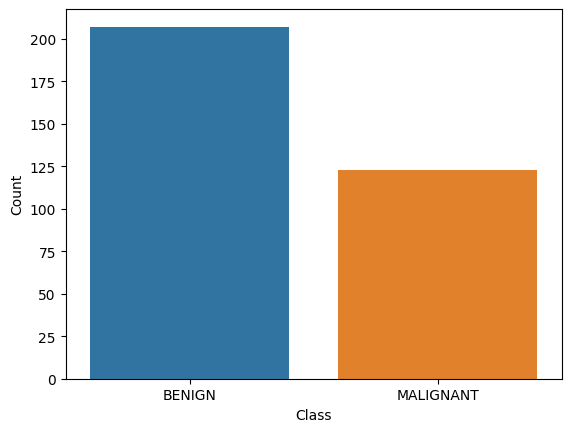

In [ ]:

class_counts = df['CLASS'].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')

In [ ]:
import cv2
import glob

# Đường dẫn đến thư mục chứa các tệp tin ảnh PGM
folder_path = '/content/mias-mammography/all-mias/'

# Lấy danh sách tệp tin PGM trong thư mục
pgm_files = glob.glob(folder_path + '*.pgm')

# Duyệt qua từng tệp tin PGM và chuyển đổi sang PNG
for pgm_file in pgm_files:
    # Đọc ảnh PGM
    image = cv2.imread(pgm_file, cv2.IMREAD_GRAYSCALE)

    # Tạo đường dẫn mới cho ảnh PNG
    png_file = pgm_file.replace('.pgm', '.png')

    # Ghi ảnh PNG
    cv2.imwrite(png_file, image)

In [ ]:
data = pd.read_csv('/content/mias-crop-mammography/description.csv')

BENIGN       207
MALIGNANT    115
Name: Classes, dtype: int64


Text(0, 0.5, 'Count')

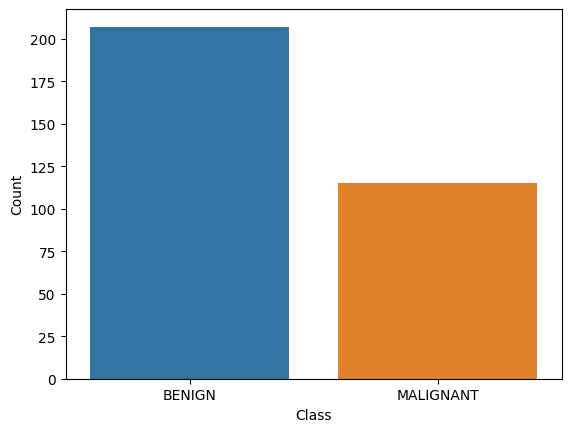

In [ ]:

data['Classes'] = ["BENIGN" if x == 'NORM' else "MALIGNANT" for x in data['Class']]
labels = data.drop_duplicates(subset=['Refnum'])['Class']
class_counts = data['Classes'].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')

In [ ]:
import pandas as pd
import os
import shutil

# Đường dẫn đến thư mục chứa ảnh
image_folder = '/content/mias-crop-mammography/images/'



# Đường dẫn đến thư mục BENIGN
benign_folder = '/content/mias-crop-mammography/BENIGN/'

# Đường dẫn đến thư mục MALIGNANT
malignant_folder = '/content/mias-crop-mammography/MALIGNANT/'


# Tạo thư mục BENIGN nếu chưa tồn tại
os.makedirs(benign_folder, exist_ok=True)

# Tạo thư mục MALIGNANT nếu chưa tồn tại
os.makedirs(malignant_folder, exist_ok=True)

# Áp dụng hàm lambda cho từng hàng trong dataframe
data.apply(lambda x: shutil.move(
    os.path.join(image_folder, x['Refnum']+'.png'),
    benign_folder if x['Classes'] == 'BENIGN' else malignant_folder
), axis=1)

0      /content/mias-crop-mammography/MALIGNANT/mdb00...
1      /content/mias-crop-mammography/MALIGNANT/mdb00...
2       /content/mias-crop-mammography/BENIGN/mdb003.png
3       /content/mias-crop-mammography/BENIGN/mdb004.png
4      /content/mias-crop-mammography/MALIGNANT/mdb00...
                             ...                        
317     /content/mias-crop-mammography/BENIGN/mdb318.png
318     /content/mias-crop-mammography/BENIGN/mdb319.png
319     /content/mias-crop-mammography/BENIGN/mdb320.png
320     /content/mias-crop-mammography/BENIGN/mdb321.png
321     /content/mias-crop-mammography/BENIGN/mdb322.png
Length: 322, dtype: object

In [ ]:
import pandas as pd
import os

# Đường dẫn đến thư mục BENIGN
benign_folder = '/content/mias-crop-mammography/BENIGN/'

# Đường dẫn đến thư mục MALIGNANT
malignant_folder = '/content/mias-crop-mammography/MALIGNANT/'

# Tạo cột mới "Path" và lưu đường dẫn vào đó
data['Path'] = data.apply(lambda row: os.path.join(benign_folder if row['Classes'] == 'BENIGN' else malignant_folder, row['Refnum'] + '.png'), axis=1)
data['Labels'] = data['Classes'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)
# Lưu lại tệp CSV đã cập nhật
data.to_csv('/content/mias-crop-mammography/description_new.csv', index=False)


In [ ]:
data.head()

,Refnum,Bg,Class,Severity,X,Y,Radius,Path,Cancer,Path_save,Classes,Labels
0,mdb001,G,CIRC,B,535.0,425.0,197.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb001.png,MALIGNANT,1
1,mdb002,G,CIRC,B,522.0,280.0,69.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb002.png,MALIGNANT,1
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,/content/mias-crop-mammography/BENIGN/mdb003.png,0,images/mdb003.png,BENIGN,0
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,/content/mias-crop-mammography/BENIGN/mdb004.png,0,images/mdb004.png,BENIGN,0
4,mdb005,F,CIRC,B,477.0,133.0,30.0,/content/mias-crop-mammography/MALIGNANT/mdb00...,0,images/mdb005.png,MALIGNANT,1


In [ ]:
import os
import random
import shutil

data_dir = "/content/mias-crop-mammography"  # Đường dẫn đến thư mục chứa BENIGN và MALIGNANT
train_dir = "final_mias-crop-mammography/train"  # Tên thư mục tập train
test_dir = "final_mias-crop-mammography/valid"  # Tên thư mục tập test
train_ratio = 0.9  # Tỷ lệ tập train (90%)

# Tạo thư mục tập train và tập test
os.makedirs(os.path.join(train_dir, "BENIGN"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "MALIGNANT"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "BENIGN"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "MALIGNANT"), exist_ok=True)

# Lấy danh sách tệp tin trong thư mục BENIGN
benign_files = os.listdir(os.path.join(data_dir, "BENIGN"))
# Lấy danh sách tệp tin trong thư mục MALIGNANT
malignant_files = os.listdir(os.path.join(data_dir, "MALIGNANT"))

# Xáo trộn danh sách tệp tin BENIGN và MALIGNANT
random.shuffle(benign_files)
random.shuffle(malignant_files)

# Số lượng tệp tin tập train từ BENIGN và MALIGNANT
train_benign_count = int(len(benign_files) * train_ratio)
train_malignant_count = int(len(malignant_files) * train_ratio)

# Sao chép tệp tin từ BENIGN vào tập train
for file in benign_files[:train_benign_count]:
    src = os.path.join(data_dir, "BENIGN", file)
    dst = os.path.join(train_dir, "BENIGN", file)
    shutil.copyfile(src, dst)

# Sao chép tệp tin từ BENIGN vào tập test
for file in benign_files[train_benign_count:]:
    src = os.path.join(data_dir, "BENIGN", file)
    dst = os.path.join(test_dir, "BENIGN", file)
    shutil.copyfile(src, dst)

# Sao chép tệp tin từ MALIGNANT vào tập train
for file in malignant_files[:train_malignant_count]:
    src = os.path.join(data_dir, "MALIGNANT", file)
    dst = os.path.join(train_dir, "MALIGNANT", file)
    shutil.copyfile(src, dst)

# Sao chép tệp tin từ MALIGNANT vào tập test
for file in malignant_files[train_malignant_count:]:
    src = os.path.join(data_dir, "MALIGNANT", file)
    dst = os.path.join(test_dir, "MALIGNANT", file)
    shutil.copyfile(src, dst)


In [ ]:
!zip -r /content/b_cancer_data1_Minas.zip /content/final_mias-crop-mammography


  adding: content/final_mias-crop-mammography/ (stored 0%)
  adding: content/final_mias-crop-mammography/valid/ (stored 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/ (stored 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb173.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb027.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb164.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb087.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb251.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb200.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb109.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb006.png (deflated 0%)
  adding: content/final_mias-crop-mammography/valid/BENIGN/mdb189.png (deflated 0%)
  adding: content/final_mias-crop-mammography/va

In [ ]:
# import os
# import torch
# import torch.nn as nn
# from opacus import PrivacyEngine
# from torch.optim import lr_scheduler
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split
# from torch.utils.data.sampler import SubsetRandomSampler
# from tqdm import tqdm

# class Client(nn.Module):
#     def __init__(
#         self, data_dir, batch_size, epoch, dp, sigma, grad_norm, mu, device, model,
#         percentage_of_dataset, dataset_name
#     ):
#         super(Client, self).__init__()
#         self.batch_size = batch_size
#         self.epoch = epoch
#         self.dp = dp
#         self.sigma = sigma
#         self.grad_norm = grad_norm
#         self.device = device
#         self.mu = mu
#         self.model = model
#         self.data_dir = data_dir
#         self.percentage_of_dataset = percentage_of_dataset
#         self.dataset_name = dataset_name

#     def load_datasets(self):
#         # Define data transformations for train and valid sets
#         data_transforms = {
#             'train': transforms.Compose([
#                 transforms.Resize((224, 224)),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomRotation(10),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ]),
#             'valid': transforms.Compose([
#                 transforms.Resize(256),
#                 transforms.CenterCrop(224),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ]),
#         }

#         # Load train and valid datasets
#         trainset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), data_transforms['train'])
#         testset = datasets.ImageFolder(os.path.join(self.data_dir, 'valid'), data_transforms['valid'])

#         # Calculate sizes for train and valid subsets
#         train_size = int(len(trainset) * self.percentage_of_dataset)
#         valid_size = int(len(testset) * self.percentage_of_dataset)

#         # Randomly select train and valid indices
#         train_indices = torch.randperm(len(trainset))[:train_size].tolist()
#         valid_indices = torch.randperm(len(testset))[:valid_size].tolist()

#         # Create samplers for train and valid subsets
#         train_sampler = SubsetRandomSampler(train_indices)
#         valid_sampler = SubsetRandomSampler(valid_indices)

#         # Create train and valid data loaders
#         trainloader = DataLoader(trainset, batch_size=self.batch_size, sampler=train_sampler)
#         validloader = DataLoader(testset, batch_size=self.batch_size, sampler=valid_sampler)

#         # Calculate the total number of examples
#         num_examples = len(train_sampler) + len(valid_sampler)

#         return trainloader, validloader, num_examples

#     def train(self, trainloader, validloader):
#         # Move the model to the specified device
#         self.model = self.model.to(self.device)
#         model = self.model.train()

#         log_dict = {
#             'training_loss_per_epoch': [],
#             'validation_loss_per_epoch': [],
#             'training_accuracy_per_epoch': [],
#             'validation_accuracy_per_epoch': []
#         }

#         # Define optimizer, loss criterion, and learning rate scheduler
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.9)
#         criterion = nn.CrossEntropyLoss()
#         exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#         print(f"Training {self.dataset_name} dataset with {self.epoch} local epoch(s)")

#         if self.dp:
#             # Apply differential privacy to the model
#             privacy_engine = PrivacyEngine(secure_mode=False)
#             model, optimizer, trainloader = privacy_engine.make_private(
#                 module=model,
#                 optimizer=optimizer,
#                 data_loader=trainloader,
#                 noise_multiplier=self.sigma,
#                 max_grad_norm=self.grad_norm
#             )

#         # Train the model
#         for epoch in range(self.epoch):
#             print('training...')
#             running_loss = 0.0
#             total = 0.0
#             correct = 0
#             for data in tqdm(trainloader):
#                 images, labels = data[0].to(self.device), data[1].to(self.device)

#                 # Zero the parameter gradients
#                 optimizer.zero_grad()

#                 # Forward pass, backward pass, and optimization
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 running_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#             loss = running_loss
#             accuracy = correct / total

#             exp_lr_scheduler.step()

#             # Log training loss and accuracy for the epoch
#             log_dict['training_accuracy_per_epoch'].append(accuracy / len(trainloader))
#             log_dict['training_loss_per_epoch'].append(loss / len(trainloader))

#             print('Epoch is: %d, Train acc: %.4f, Train loss: %.4f' % (
#                 (epoch + 1), accuracy / len(trainloader), loss / len(trainloader))
#             )

#             model = self.model.eval()
#             criterion = nn.CrossEntropyLoss()

#             valid_total = 0.0
#             valid_correct = 0
#             valid_running_loss = 0.0

#             with torch.no_grad():
#                 # Validate the model
#                 for data in tqdm(validloader):
#                     images, labels = data[0].to(self.device), data[1].to(self.device)
#                     outputs = model(images)
#                     loss = criterion(outputs, labels)
#                     valid_running_loss += loss.item()
#                     _, predicted = torch.max(outputs.data, 1)
#                     valid_total += labels.size(0)
#                     valid_correct += (predicted == labels).sum().item()

#             test_loss = valid_running_loss / len(validloader)
#             test_accuracy = valid_correct / valid_total

#             # Log validation loss and accuracy for the epoch
#             log_dict['validation_accuracy_per_epoch'].append(test_accuracy)
#             log_dict['validation_loss_per_epoch'].append(test_loss)

#             print('Validation Accuracy: %.4f, Validation Loss: %.4f' % (test_accuracy, test_loss))

#         return log_dict, model


In [ ]:
import os
import torch
import torch.nn as nn
# from opacus import PrivacyEngine
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from typing import Tuple, Dict, Union, Optional

FL_ROUND: int = 0

eval_list: List[Dict[str, Union[str, int, float]]] = []


class Client(nn.Module):
    def __init__(
        self,
        data_dir: str,
        batch_size: int,
        epoch: int,
        device: str,
        model: Optional[nn.Module],
        percentage_of_dataset: float,
        dataset_name: str,
        mode: str,
        server_model_path: str,
        client_model_path: str,
    ):
        super(Client, self).__init__()
        self.batch_size = batch_size
        self.epoch = epoch
        self.device = device
        self.model = model
        self.data_dir = data_dir
        self.percentage_of_dataset = percentage_of_dataset
        self.dataset_name = dataset_name
        self.mode = mode
        self.trainloader = None
        self.validloader = None
        self.num_examples = None
        self.server_model_path = server_model_path
        self.client_model_path = client_model_path

    def load_datasets(self) -> Tuple[DataLoader, DataLoader, Dict[str, Union[str, int]]]:
        # Define data transformations for train and valid sets
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'valid': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

        # Load train and valid datasets
        trainset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), data_transforms['train'])
        testset = datasets.ImageFolder(os.path.join(self.data_dir, 'valid'), data_transforms['valid'])

        # Calculate sizes for train and valid subsets
        train_size = int(len(trainset) * self.percentage_of_dataset)
        valid_size = int(len(testset) * self.percentage_of_dataset)

        # Randomly select train and valid indices
        train_indices = torch.randperm(len(trainset))[:train_size].tolist()
        valid_indices = torch.randperm(len(testset))[:valid_size].tolist()

        # Create samplers for train and valid subsets
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        # Create train and valid data loaders
        self.trainloader = DataLoader(trainset, batch_size=self.batch_size, sampler=train_sampler)
        self.validloader = DataLoader(testset, batch_size=self.batch_size, sampler=valid_sampler)

        train_length = len(train_sampler)
        valid_length = len(valid_sampler)
        total_samples = train_length + valid_length
        self.num_examples = {
            'dataset': self.dataset_name,
            'trainloader': train_length,
            'validloader': valid_length,
            'total_samples' : total_samples
        }
        class_names = trainset.classes
        malignant_class_index = class_names.index('MALIGNANT')
        benign_class_index = class_names.index('BENIGN')
        print("MALIGNANT: ",malignant_class_index)
        print("BENIGN:",benign_class_index)  # In ra chỉ số của lớp MALIGNANT (có thể là 0 hoặc 1)

        return self.trainloader, self.validloader, self.num_examples

    def set_parameters(self, server_model_path: str) -> None:
        """Load model parameters from a file."""
        state_dict = torch.load(server_model_path)
        self.model.load_state_dict(state_dict)

    def get_parameters(self, client_model_path: str) -> None:
        """Save model parameters to a file."""
        torch.save(self.model.state_dict(), client_model_path)

    def fit(self) -> Tuple[None, int, Dict[str, Union[str, int, float]]]:
        self.set_parameters(self.server_model_path)

        if self.model is not None:
            print("Model fitting done...")
        else:
            print("Cannot fit the model")
        print("Testing data with model from server....")
        test_loss, test_accuracy = test(
            self.model, self.trainloader, self.dataset_name, device=self.device
        )
        test_dict = {
            "dataset": self.dataset_name,
            "fl_round": FL_ROUND,
            "strategy": self.mode,
            "train_loss": test_loss,
            "train_accuracy": test_accuracy,
            "total_samples" : self.num_examples['total_samples']
        }

        loss, accuracy = train(
            self.model,
            self.trainloader,
            self.dataset_name,
            epochs=self.epoch,
            device=self.device,
        )
        eval_list.append(test_dict)

        self.get_parameters(self.client_model_path)
        return (
            None,
            self.num_examples['trainloader'],
            {"loss": loss, "accuracy": accuracy},
        )

    def evaluate(self) -> Tuple[float, int, Dict[str, Union[str, int, float]]]:
        global FL_ROUND
        print("Testing data with model from after training....")
        loss, accuracy = test(
            self.model, self.validloader, self.dataset_name, device=self.device
        )
        test_dict = {
            "dataset": self.dataset_name,
            "fl_round": FL_ROUND,
            "strategy": self.mode,
            "test_loss": loss,
            "test_accuracy": accuracy,
            "total_samples" : self.num_examples['total_samples']
        }
        eval_list.append(test_dict)
        FL_ROUND += 1
        return (
            float(loss),
            self.num_examples["validloader"],
            {"loss": loss, "accuracy": accuracy},
        )


def train(
    model: nn.Module,
    traindata: DataLoader,
    dataset: str,
    epochs: int,
    device: str
) -> Tuple[float, float]:
    """Train the network."""
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    print(
        f"Training {dataset} dataset with {epochs} local epoch(s) w/ {len(traindata)} batches each"
    )

    # Train the network
    model.to(device)
    model.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total = 0.0
        correct = 0
        for i, data in enumerate(tqdm(traindata), 0):
            images, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # pylint: disable=no-member
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_batch = running_loss / len(traindata)
            accuracy = correct / total
            if i == len(traindata) - 1:  # print every 100 mini-batches
                print(
                    f"Train Dataset {dataset} with [Epoch {epoch+1}, {i+1} mini-batches] loss: {loss_batch} accuracy: {accuracy}"
                )
                running_loss = 0.0
        loss = loss / len(traindata)
    return loss, accuracy


def test(
    model: nn.Module,
    testloader: DataLoader,
    dataset_name: str,
    device: str
) -> Tuple[float, float]:
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    valid_total = 0.0
    valid_correct = 0
    valid_running_loss = 0.0

    with torch.no_grad():
        # Validate the model
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    test_loss = valid_running_loss / len(testloader)
    test_accuracy = valid_correct / valid_total

    print('Validation Accuracy: %.4f, Validation Loss: %.4f' % (test_accuracy, test_loss))

    return test_loss, test_accuracy


In [ ]:
# """Define the model architecture."""


# from torch import nn


# # pylint: disable=unsubscriptable-object,too-many-instance-attributes
# class CNNModel(nn.Module):
#     """Model for benchmark experiment on Digits."""

#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 64, 5, 1, 2)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 64, 5, 1, 2)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 5, 1, 2)
#         self.bn3 = nn.BatchNorm2d(128)

#         self.fc1 = nn.Linear(6272, 2048)
#         self.bn4 = nn.BatchNorm1d(2048)
#         self.fc2 = nn.Linear(2048, 512)
#         self.bn5 = nn.BatchNorm1d(512)
#         self.fc3 = nn.Linear(512, 2)

#     # pylint: disable=arguments-differ,invalid-name
#     def forward(self, x):
#         """Forward pass."""
#         x = nn.functional.relu(self.bn1(self.conv1(x)))
#         x = nn.functional.max_pool2d(x, 2)

#         x = nn.functional.relu(self.bn2(self.conv2(x)))
#         x = nn.functional.max_pool2d(x, 2)

#         x = nn.functional.relu(self.bn3(self.conv3(x)))

#         x = x.view(x.shape[0], -1)

#         x = self.fc1(x)
#         x = self.bn4(x)
#         x = nn.functional.relu(x)

#         x = self.fc2(x)
#         x = self.bn5(x)
#         x = nn.functional.relu(x)

#         x = self.fc3(x)
#         return x

In [ ]:
import torch
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# model = models.densenet121(pretrained=True)
for param in model.parameters():
  param.requires_grad = True
model.classifier = nn.Linear(1280, 2)
net = model.to(DEVICE)
summary(model, (3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 68.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
torch.save(net.state_dict(), "/content/model.pt")
for key in net.state_dict().keys():
  print(key)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.0.1.running_mean
features.1.conv.0.1.running_var
features.1.conv.0.1.num_batches_tracked
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.1.conv.2.running_mean
features.1.conv.2.running_var
features.1.conv.2.num_batches_tracked
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.0.1.running_mean
features.2.conv.0.1.running_var
features.2.conv.0.1.num_batches_tracked
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.1.1.running_mean
features.2.conv.1.1.running_var
features.2.conv.1.1.num_batches_tracked
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.2.conv.3.running_mean
features.2.conv.3.running_var


In [ ]:
import os
import torch
import copy
# from client import Client, eval_list
import pickle

# Các khai báo và đường dẫn
data_dir = "/content/b_cancer_data"
batch_size = 32
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
percentage_of_dataset = 0.5
dataset_name = "histopathological_breast_cancer_dataset"
mode = "fedbn"
server_model_path = "/content/model.pt"
client_model_path = "/content/model_client1.pt"

if __name__ == "__main__":
    # Khởi tạo đối tượng Client
    client1 = Client(
        data_dir=data_dir,
        batch_size=batch_size,
        epoch=epochs,
        device=device,
        model=None,  # Khởi tạo với None, sẽ được gán sau
        percentage_of_dataset=percentage_of_dataset,
        dataset_name=dataset_name,
        mode=mode,
        server_model_path=server_model_path,
        client_model_path=client_model_path
    )

    # Load dữ liệu
    trainloader, validloader, num_examples = client1.load_datasets()

    # Gán model
    # model = net  # Thay YourModel() bằng model của bạn
    client1.model = copy.deepcopy(net)

    # Fit model
    client1.fit()

    # Evaluate model
    client1.evaluate()
    client1.model
    # Save eval_list to a file
    with open('eval_list1.pkl', 'wb') as f:
        pickle.dump(eval_list, f)


MALIGNANT:  1
BENIGN: 0
Model fitting done...
Testing data with model from server....


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Validation Accuracy: 0.6674, Validation Loss: 0.6441
Training histopathological_breast_cancer_dataset dataset with 30 local epoch(s) w/ 100 batches each


100%|██████████| 100/100 [08:14<00:00,  4.95s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 1, 100 mini-batches] loss: 0.32171959020197394 accuracy: 0.8647540983606558


100%|██████████| 100/100 [08:04<00:00,  4.85s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 2, 100 mini-batches] loss: 0.1449568527750671 accuracy: 0.9467213114754098


100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 3, 100 mini-batches] loss: 0.11436075178906321 accuracy: 0.9561790668348046


100%|██████████| 100/100 [08:12<00:00,  4.92s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 4, 100 mini-batches] loss: 0.08800696903839707 accuracy: 0.9637452711223203


100%|██████████| 100/100 [08:14<00:00,  4.95s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 5, 100 mini-batches] loss: 0.08067648470401764 accuracy: 0.9703656998738966


100%|██████████| 100/100 [08:01<00:00,  4.82s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 6, 100 mini-batches] loss: 0.058311594636179506 accuracy: 0.978562421185372


100%|██████████| 100/100 [07:35<00:00,  4.56s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 7, 100 mini-batches] loss: 0.062363241077400745 accuracy: 0.9766708701134931


100%|██████████| 100/100 [08:05<00:00,  4.85s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 8, 100 mini-batches] loss: 0.04581557259894908 accuracy: 0.9826607818411097


100%|██████████| 100/100 [08:03<00:00,  4.84s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 9, 100 mini-batches] loss: 0.05691986021935008 accuracy: 0.9817150063051703


100%|██████████| 100/100 [07:35<00:00,  4.55s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 10, 100 mini-batches] loss: 0.07686520609306172 accuracy: 0.9807692307692307


100%|██████████| 100/100 [08:07<00:00,  4.87s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 11, 100 mini-batches] loss: 0.09464965004939586 accuracy: 0.9713114754098361


100%|██████████| 100/100 [08:06<00:00,  4.87s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 12, 100 mini-batches] loss: 0.04185197138926014 accuracy: 0.9864438839848676


100%|██████████| 100/100 [08:18<00:00,  4.99s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 13, 100 mini-batches] loss: 0.04969820561236702 accuracy: 0.9845523329129886


100%|██████████| 100/100 [07:48<00:00,  4.68s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 14, 100 mini-batches] loss: 0.027859342566225676 accuracy: 0.9902269861286255


100%|██████████| 100/100 [08:15<00:00,  4.96s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 15, 100 mini-batches] loss: 0.02483427086903248 accuracy: 0.9918032786885246


100%|██████████| 100/100 [08:11<00:00,  4.91s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 16, 100 mini-batches] loss: 0.02984833179274574 accuracy: 0.9918032786885246


100%|██████████| 100/100 [08:00<00:00,  4.80s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 17, 100 mini-batches] loss: 0.0424381673859898 accuracy: 0.9870744010088273


100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 18, 100 mini-batches] loss: 0.08711808266118169 accuracy: 0.9668978562421185


100%|██████████| 100/100 [08:03<00:00,  4.84s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 19, 100 mini-batches] loss: 0.025454987209523095 accuracy: 0.9924337957124842


100%|██████████| 100/100 [08:05<00:00,  4.86s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 20, 100 mini-batches] loss: 0.027164530570153146 accuracy: 0.9918032786885246


100%|██████████| 100/100 [07:44<00:00,  4.65s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 21, 100 mini-batches] loss: 0.030757953049615025 accuracy: 0.9895964691046658


100%|██████████| 100/100 [07:35<00:00,  4.55s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 22, 100 mini-batches] loss: 0.01767783310919185 accuracy: 0.9924337957124842


100%|██████████| 100/100 [07:32<00:00,  4.53s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 23, 100 mini-batches] loss: 0.030668816940742544 accuracy: 0.9977931904161412


100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 24, 100 mini-batches] loss: 0.06493453275179491 accuracy: 0.9836065573770492


100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 25, 100 mini-batches] loss: 0.03491008244396653 accuracy: 0.9883354350567465


100%|██████████| 100/100 [07:38<00:00,  4.58s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 26, 100 mini-batches] loss: 0.014125302946777083 accuracy: 0.9971626733921816


100%|██████████| 100/100 [07:31<00:00,  4.52s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 27, 100 mini-batches] loss: 0.020065709568734748 accuracy: 0.9943253467843631


100%|██████████| 100/100 [07:37<00:00,  4.58s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 28, 100 mini-batches] loss: 0.027539105783216656 accuracy: 0.9943253467843631


100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 29, 100 mini-batches] loss: 0.03665010615484789 accuracy: 0.987389659520807


100%|██████████| 100/100 [07:32<00:00,  4.52s/it]


Train Dataset histopathological_breast_cancer_dataset with [Epoch 30, 100 mini-batches] loss: 0.03847036977502285 accuracy: 0.9949558638083228
Testing data with model from after training....


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

Validation Accuracy: 0.5537, Validation Loss: 2.3540


In [ ]:
import os
import torch
# from client import Client, eval_list
import pickle
import copy

# Các khai báo và đường dẫn
data_dir = "/content/final_mias-crop-mammography"
batch_size = 32
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
percentage_of_dataset = 0.5
dataset_name = "final_mias-crop-mammography"
mode = "fedbn"
server_model_path = "/content/model.pt"
client_model_path = "/content/model_client2.pt"

if __name__ == "__main__":
    # Khởi tạo đối tượng Client
    client2 = Client(
        data_dir=data_dir,
        batch_size=batch_size,
        epoch=epochs,
        device=device,
        model=None,  # Khởi tạo với None, sẽ được gán sau
        percentage_of_dataset=percentage_of_dataset,
        dataset_name=dataset_name,
        mode=mode,
        server_model_path=server_model_path,
        client_model_path=client_model_path
    )

    # Load dữ liệu
    trainloader, validloader, num_examples = client2.load_datasets()

    # Gán model
    # model = net  # Thay YourModel() bằng model của bạn
    client2.model = copy.deepcopy(net)

    # Fit model
    client2.fit()

    # Evaluate model
    client2.evaluate()
    client2.model
    # Save eval_list to a file
    with open('eval_list2.pkl', 'wb') as f:
        pickle.dump(eval_list, f)


MALIGNANT:  1
BENIGN: 0
Model fitting done...
Testing data with model from server....


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Validation Accuracy: 0.3958, Validation Loss: 0.7161
Training final_mias-crop-mammography dataset with 30 local epoch(s) w/ 5 batches each


100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Train Dataset final_mias-crop-mammography with [Epoch 1, 5 mini-batches] loss: 0.875648844242096 accuracy: 0.4583333333333333


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]


Train Dataset final_mias-crop-mammography with [Epoch 2, 5 mini-batches] loss: 0.7096258759498596 accuracy: 0.6041666666666666


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Train Dataset final_mias-crop-mammography with [Epoch 3, 5 mini-batches] loss: 0.683810544013977 accuracy: 0.5833333333333334


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Train Dataset final_mias-crop-mammography with [Epoch 4, 5 mini-batches] loss: 0.6222689628601075 accuracy: 0.6319444444444444


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Train Dataset final_mias-crop-mammography with [Epoch 5, 5 mini-batches] loss: 0.5997381031513214 accuracy: 0.6319444444444444


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Train Dataset final_mias-crop-mammography with [Epoch 6, 5 mini-batches] loss: 0.6270370125770569 accuracy: 0.6527777777777778


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Train Dataset final_mias-crop-mammography with [Epoch 7, 5 mini-batches] loss: 0.619008457660675 accuracy: 0.6388888888888888


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Train Dataset final_mias-crop-mammography with [Epoch 8, 5 mini-batches] loss: 0.6308658957481384 accuracy: 0.6666666666666666


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Train Dataset final_mias-crop-mammography with [Epoch 9, 5 mini-batches] loss: 0.5265998244285583 accuracy: 0.6944444444444444


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Train Dataset final_mias-crop-mammography with [Epoch 10, 5 mini-batches] loss: 0.5387099742889404 accuracy: 0.75


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Train Dataset final_mias-crop-mammography with [Epoch 11, 5 mini-batches] loss: 0.5144441366195679 accuracy: 0.7152777777777778


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Train Dataset final_mias-crop-mammography with [Epoch 12, 5 mini-batches] loss: 0.49268481135368347 accuracy: 0.7152777777777778


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Train Dataset final_mias-crop-mammography with [Epoch 13, 5 mini-batches] loss: 0.44033958315849303 accuracy: 0.7569444444444444


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Train Dataset final_mias-crop-mammography with [Epoch 14, 5 mini-batches] loss: 0.40250688791275024 accuracy: 0.8402777777777778


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Train Dataset final_mias-crop-mammography with [Epoch 15, 5 mini-batches] loss: 0.3724543213844299 accuracy: 0.8611111111111112


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Train Dataset final_mias-crop-mammography with [Epoch 16, 5 mini-batches] loss: 0.3831790447235107 accuracy: 0.8402777777777778


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Train Dataset final_mias-crop-mammography with [Epoch 17, 5 mini-batches] loss: 0.3654105305671692 accuracy: 0.8611111111111112


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Train Dataset final_mias-crop-mammography with [Epoch 18, 5 mini-batches] loss: 0.2707749158143997 accuracy: 0.8819444444444444


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Train Dataset final_mias-crop-mammography with [Epoch 19, 5 mini-batches] loss: 0.2892758071422577 accuracy: 0.875


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Train Dataset final_mias-crop-mammography with [Epoch 20, 5 mini-batches] loss: 0.2410237520933151 accuracy: 0.9166666666666666


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Train Dataset final_mias-crop-mammography with [Epoch 21, 5 mini-batches] loss: 0.19971843659877778 accuracy: 0.9305555555555556


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Train Dataset final_mias-crop-mammography with [Epoch 22, 5 mini-batches] loss: 0.2649897575378418 accuracy: 0.8541666666666666


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Train Dataset final_mias-crop-mammography with [Epoch 23, 5 mini-batches] loss: 0.14871377348899842 accuracy: 0.9722222222222222


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Train Dataset final_mias-crop-mammography with [Epoch 24, 5 mini-batches] loss: 0.23071872889995576 accuracy: 0.9097222222222222


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Train Dataset final_mias-crop-mammography with [Epoch 25, 5 mini-batches] loss: 0.21112968176603317 accuracy: 0.9166666666666666


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Train Dataset final_mias-crop-mammography with [Epoch 26, 5 mini-batches] loss: 0.11339948922395707 accuracy: 0.9791666666666666


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Train Dataset final_mias-crop-mammography with [Epoch 27, 5 mini-batches] loss: 0.1527193605899811 accuracy: 0.9513888888888888


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Train Dataset final_mias-crop-mammography with [Epoch 28, 5 mini-batches] loss: 0.17709389477968215 accuracy: 0.9375


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Train Dataset final_mias-crop-mammography with [Epoch 29, 5 mini-batches] loss: 0.14020902812480926 accuracy: 0.9583333333333334


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Train Dataset final_mias-crop-mammography with [Epoch 30, 5 mini-batches] loss: 0.1360576257109642 accuracy: 0.9722222222222222
Testing data with model from after training....


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

Validation Accuracy: 0.6875, Validation Loss: 1.6299


In [ ]:
# Load eval_list from file
with open('eval_list1.pkl', 'rb') as f:
    eval_list = pickle.load(f)
for i in eval_list:
  print(i)

{'dataset': 'histopathological_breast_cancer_dataset', 'fl_round': 0, 'strategy': 'fedbn', 'train_loss': 0.6440936607122422, 'train_accuracy': 0.6674022698612863, 'total_samples': 3954}
{'dataset': 'histopathological_breast_cancer_dataset', 'fl_round': 0, 'strategy': 'fedbn', 'test_loss': 2.3539976978302004, 'test_accuracy': 0.5537084398976982, 'total_samples': 3954}


In [ ]:
# # Khởi tạo các tham số
# data_dir = '/content/b_cancer_data'
# batch_size = 32
# epoch = 60
# dp = False
# sigma = 0.1
# grad_norm = 1.0
# mu = 1.0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Khởi tạo mô hình
# model = model  # Thay thế bằng mô hình của bạn
# percentage_of_dataset = 0.8
# dataset_name = 'Histopathological Breast Cancer'

# # Khởi tạo đối tượng Client
# client = Client(data_dir, batch_size, epoch, dp, sigma, grad_norm, mu, device, model, percentage_of_dataset, dataset_name)

# # Tải dữ liệu huấn luyện và kiểm tra
# trainloader, validloader, num_examples = client.load_datasets()

# # Huấn luyện và kiểm tra mô hình
# log_dict, model = client.train(trainloader,validloader)

# ## Save model
# torch.save(model.state_dict(), '/content/model2.pt')

In [ ]:
print(id(client1.model))
print(id(client2.model))


140290109540528
140290703508384


In [ ]:
state_dict1 = client1.model.state_dict()
state_dict2 = client2.model.state_dict()

# Kiểm tra các khóa trong state_dict của cả hai đối tượng
common_keys = set(state_dict1.keys()).intersection(state_dict2.keys())

# So sánh giá trị của các khóa chung
for key in common_keys:
    tensor1 = state_dict1[key]
    tensor2 = state_dict2[key]
    if torch.all(torch.eq(tensor1, tensor2)):
        print(f"Giá trị của khóa '{key}' giống nhau.")
    else:
        print(f"Giá trị của khóa '{key}' khác nhau.")


Giá trị của khóa 'features.7.conv.0.1.weight' khác nhau.
Giá trị của khóa 'features.2.conv.3.running_var' khác nhau.
Giá trị của khóa 'features.9.conv.2.weight' khác nhau.
Giá trị của khóa 'features.12.conv.1.1.bias' khác nhau.
Giá trị của khóa 'features.14.conv.1.0.weight' khác nhau.
Giá trị của khóa 'features.4.conv.1.1.weight' khác nhau.
Giá trị của khóa 'features.16.conv.1.1.weight' khác nhau.
Giá trị của khóa 'features.9.conv.1.1.num_batches_tracked' khác nhau.
Giá trị của khóa 'features.11.conv.1.1.running_var' khác nhau.
Giá trị của khóa 'features.13.conv.3.running_mean' khác nhau.
Giá trị của khóa 'features.6.conv.1.1.bias' khác nhau.
Giá trị của khóa 'features.0.1.running_var' khác nhau.
Giá trị của khóa 'features.5.conv.1.1.num_batches_tracked' khác nhau.
Giá trị của khóa 'features.3.conv.1.1.running_mean' khác nhau.
Giá trị của khóa 'features.5.conv.3.running_var' khác nhau.
Giá trị của khóa 'features.3.conv.1.1.running_var' khác nhau.
Giá trị của khóa 'features.5.conv.0.0.w

In [ ]:
import torch

# Load state_dict of the server model
server_model_state_dict = torch.load("/content/model.pt")

# Compare state_dict of client1.model with server_model_state_dict
client1_state_dict = client1.model.state_dict()
for key in client1_state_dict.keys():
    tensor1 = client1_state_dict[key]
    tensor2 = server_model_state_dict[key]
    if torch.all(torch.eq(tensor1, tensor2)):
        print(f"Giá trị của khóa '{key}' trong client1.model giống như server_model.")
    else:
        print(f"Giá trị của khóa '{key}' trong client1.model khác với server_model.")

# Compare state_dict of client2.model with server_model_state_dict
client2_state_dict = client2.model.state_dict()
for key in client2_state_dict.keys():
    tensor1 = client2_state_dict[key]
    tensor2 = server_model_state_dict[key]
    if torch.all(torch.eq(tensor1, tensor2)):
        print(f"Giá trị của khóa '{key}' trong client2.model giống như server_model.")
    else:
        print(f"Giá trị của khóa '{key}' trong client2.model khác với server_model.")


Giá trị của khóa 'features.0.0.weight' trong client1.model khác với server_model.
Giá trị của khóa 'features.0.1.weight' trong client1.model khác với server_model.
Giá trị của khóa 'features.0.1.bias' trong client1.model khác với server_model.
Giá trị của khóa 'features.0.1.running_mean' trong client1.model khác với server_model.
Giá trị của khóa 'features.0.1.running_var' trong client1.model khác với server_model.
Giá trị của khóa 'features.0.1.num_batches_tracked' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.conv.0.0.weight' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.conv.0.1.weight' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.conv.0.1.bias' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.conv.0.1.running_mean' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.conv.0.1.running_var' trong client1.model khác với server_model.
Giá trị của khóa 'features.1.con

In [ ]:
from IPython.core.display import deepcopy
import torch

model22 = copy.deepcopy(net)

model22.load_state_dict(torch.load('/content/model_client2.pt'))

model11 = copy.deepcopy(net)

model11.load_state_dict(torch.load('/content/model_client.pt'))

state_dict_22 = model22.state_dict()
state_dict_11 = model11.state_dict()

# Kiểm tra các khóa có trong state_dict của model22
for key in state_dict_22:
    if key in state_dict_11:
        tensor_equal = torch.equal(state_dict_22[key], state_dict_11[key])
        if not tensor_equal:
            print("Các giá trị trong tensor của hai model khác nhau tại khóa", key)
    else:
        print("Khóa", key, "không có trong state_dict của model11")

# Kiểm tra các khóa có trong state_dict của model11 nhưng không có trong model22
for key in state_dict_11:
    if key not in state_dict_22:
        print("Khóa", key, "không có trong state_dict của model22")


FileNotFoundError: ignored

In [ ]:
# Lấy danh sách tên trọng số của hai mô hình
weights_model22 = list(model22.state_dict().keys())
weights_model11 = list(model11.state_dict().keys())

# Kiểm tra xem hai danh sách tên trọng số có giống nhau hay không
if weights_model22 == weights_model11:
    print("Các tên trọng số trong hai mô hình giống nhau")
else:
    print("Các tên trọng số trong hai mô hình khác nhau")


In [ ]:
import torch

# Khởi tạo mô hình model22
model22 = copy.deepcopy(net)

model22.load_state_dict(torch.load('/content/model_client2.pt'))

# Khởi tạo mô hình model11
model11 = copy.deepcopy(net)

model11.load_state_dict(torch.load('/content/model_client.pt'))

# So sánh các giá trị của trọng số
is_equal = True
for p1, p2 in zip(model22.parameters(), model11.parameters()):
    if not torch.equal(p1.data, p2.data):
        is_equal = False
        break

if is_equal:
    print("Các giá trị của trọng số trong hai mô hình giống nhau.")
else:
    print("Các giá trị của trọng số trong hai mô hình không giống nhau.")


In [ ]:
def compare_files(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        content1 = f1.read()
        content2 = f2.read()

    if content1 == content2:
        print("Hai file giống nhau hoàn toàn.")
        return

    # Tìm các điểm khác nhau
    diff_points = []
    for i in range(len(content1)):
        if content1[i] != content2[i]:
            diff_points.append(i)

    if len(diff_points) > 0:
        print("Hai file khác nhau tại các điểm sau:")
        for point in diff_points:
            print(f"Vị trí: {point}, Giá trị file 1: {content1[point]}, Giá trị file 2: {content2[point]}")
    else:
        print("Hai file có cùng kích thước nhưng không giống nhau.")

# Gọi hàm để so sánh hai file
compare_files('/content/model_client.pt', '/content/model_client2.pt')


In [ ]:
# Load eval_list from file
with open('eval_list1.pkl', 'rb') as f:
    eval_list = pickle.load(f)
for i in eval_list:
  print(i)

In [ ]:
for name in model.state_dict().keys():
    print(name)

In [ ]:
import torch
import pickle
from typing import List, Dict, Tuple

import torch
import pickle
from typing import List, Dict, Tuple

class ClientOnServer:
    def __init__(self, model_path: str, eval_list_path: str):
        self.model_path = model_path
        self.eval_list_path = eval_list_path
        self.model = None
        self.eval_list = None
        self.load_model()
        self.load_eval_list()

    def load_model(self):
        state_dict = torch.load(self.model_path)
        self.model = copy.deepcopy(net)
        self.model.load_state_dict(state_dict)

    def load_eval_list(self):
        with open(self.eval_list_path, 'rb') as f:
            self.eval_list = pickle.load(f)

    def get_eval_list(self) -> List[Dict[str, float]]:
        return self.eval_list

    def get_model(self) -> Dict[str, torch.Tensor]:
        return self.model.state_dict()

    def get_samples(self) -> int:
        return self.eval_list[0]['total_samples']

    def get_FL_round(self) -> int:
        return self.eval_list[0]['fl_round']


# import torch
# from typing import List, Dict, Tuple
# # from server.clients_on_server import ClientOnServer


class Server:
    def __init__(self):
        self.clients: List[ClientOnServer] = []
        self.server_model: Dict[str, torch.Tensor] = None
        self.loaded: bool = False
        self.client_num: int = 0
        self.client_weights_ratio: List[float] = []
        self.origin_model: Dict[str, torch.Tensor] = None

    def load_server_model(self, model_path: str):
      if not self.loaded:
        state_dict = torch.load(model_path)
        self.server_model.load_state_dict(state_dict)
        self.origin_model = self.server_model.state_dict()  # Cố định origin_model lần đầu
        self.loaded = True


    def add_client(self, model_path: str, eval_list_path: str):
        client = ClientOnServer(model_path, eval_list_path)
        self.clients.append(client)
        self.client_num = len(self.clients)

    def __getitem__(self, index: int) -> ClientOnServer:
        return self.clients[index]

    def compute_client_samples_ratio(self) -> List[float]:
        total_samples = sum(client.get_samples() for client in self.clients)
        self.client_weights_ratio = [client.get_samples() / total_samples for client in self.clients]
        return self.client_weights_ratio

    def aggregate(self, args, models: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        with torch.no_grad():
            if args == 'fedbn':
                for key in self.server_model.state_dict().keys():
                    if 'bn' not in key:
                        temp = torch.zeros_like(self.server_model.state_dict()[key], dtype=torch.float32)
                        for client_idx in range(self.client_num):
                            temp.add_(models[client_idx][key], alpha=self.client_weights_ratio[client_idx])
                        self.server_model.state_dict()[key].copy_(temp)
            else:
                for key in self.server_model.state_dict().keys():
                    if 'num_batches_tracked' in key:
                        self.server_model.state_dict()[key].copy_(self.origin_model[key])
                    else:
                        temp = torch.zeros_like(self.server_model.state_dict()[key])
                        for client_idx in range(self.client_num):
                            temp.add_(models[client_idx][key], alpha=self.client_weights_ratio[client_idx])
                        self.server_model.state_dict()[key].copy_(temp)
        return self.server_model.state_dict()



    def metrics_avg(self) -> Tuple[float, float, float, float]:
        """Compute average metrics from multiple clients."""
        train_loss = 0
        train_accuracy = 0
        test_loss = 0
        test_accuracy = 0
        for client_idx in range(self.client_num):
            eval_list = self.clients[client_idx].get_eval_list()
            client_weight = self.client_weights_ratio[client_idx]
            train_loss += eval_list[0]['train_loss'] * client_weight
            train_accuracy += eval_list[0]['train_accuracy'] * client_weight
            test_loss += eval_list[1]['test_loss'] * client_weight
            test_accuracy += eval_list[1]['test_accuracy'] * client_weight
        return train_loss, train_accuracy, test_loss, test_accuracy

In [ ]:
import torch
import pickle
import argparse
from typing import List, Dict, Tuple
# from server.clients_on_server import ClientOnServer
# from server.server import Server




# parser = argparse.ArgumentParser()
# parser.add_argument('--percent', type = float, default= 0.1, help ='percentage of dataset to train and test')
# parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
# parser.add_argument('--batch', type = int, default= 32, help ='batch size')
# parser.add_argument('--round', type = int, default=100, help = 'Federated Learning for communication')
# parser.add_argument('--epochs', type = int, default=1, help = 'epochs in local worker between communication')
# parser.add_argument('--mode', type = str, default='fedbn', help='fedavg | fedbn')
# args = parser.parse_args()

# Create instances of the classes and perform the operations
if __name__ == "__main__":
    args ='fedbn'
    server = Server()
    server.server_model = copy.deepcopy(net)
    server.load_server_model('/content/model.pt')
    server.add_client('/content/model_client1.pt', '/content/eval_list1.pkl')
    server.add_client('/content/model_client2.pt', '/content/eval_list2.pkl')

    client_1: ClientOnServer = server[0]  # Access client 1 directly
    client_2: ClientOnServer = server[1]  # Access client 2 directly
    eval_list_1: List[Dict[str, float]] = client_1.get_eval_list()
    eval_list_2: List[Dict[str, float]] = client_2.get_eval_list()
    model_1: Dict[str, torch.Tensor] = client_1.get_model()
    model_2: Dict[str, torch.Tensor] = client_2.get_model()

    client_weights_ratio: List[float] = server.compute_client_samples_ratio()

    # Aggregate models
    aggregated_model: Dict[str, torch.Tensor] = server.aggregate(args, [model_1, model_2])

    # Compute average metrics
    train_loss, train_accuracy, test_loss, test_accuracy = server.metrics_avg()

    log_dict = {
        'fl_round': client_1.get_FL_round(),
        'training_loss_per_epoch': train_loss,
        'validation_loss_per_epoch': train_accuracy,
        'training_accuracy_per_epoch': test_loss,
        'validation_accuracy_per_epoch': test_accuracy,
    }

    fl_round = log_dict['fl_round']
    log_file_path = f"/content/log_dict_round_{fl_round}.pickle"

    with open(log_file_path, 'wb') as f:
        pickle.dump(log_dict, f)

     # Save global model
    torch.save(aggregated_model, '/content/global_model.pt')
    print("Global model saved to global_model.pt")





In [ ]:
print(client_1.model is server.server_model)  # True
print(client_2.model is server.server_model)  # True


In [ ]:
model11 = copy.deepcopy(net)

model11.load_state_dict(torch.load('/content/model_client1.pt'))

In [ ]:
model22 = copy.deepcopy(net)

model22.load_state_dict(torch.load('/content/model_client2.pt'))

In [ ]:
modelgl = copy.deepcopy(net)

modelgl.load_state_dict(torch.load('/content/global_model.pt'))

In [ ]:
for name, param_gl in modelgl.named_parameters():
    param_22 = model22.state_dict()[name]
    param_11 = model11.state_dict()[name]

    if torch.equal(param_gl, param_22) and torch.equal(param_gl, param_11):
        print(f"Parameters {name} are the same in all models.")
    else:
        print(f"Parameters {name} are different in at least one model.")


In [ ]:
import torch.nn as nn

class MobileNetV2(nn.Module):
    def __init__(self):
        super(MobileNetV2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            nn.Conv2d(32, 16, 1, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            nn.InvertedResidual(16, 96, 1, 6),
            nn.InvertedResidual(96, 144, 2, 6),
            nn.InvertedResidual(144, 24, 2, 6),
            nn.InvertedResidual(24, 144, 2, 6),
            nn.InvertedResidual(144, 32, 2, 6),
            nn.InvertedResidual(32, 192, 1, 6),
            nn.InvertedResidual(192, 192, 2, 6),
            nn.InvertedResidual(192, 48, 2, 6),
            nn.InvertedResidual(48, 192, 2, 6),
            nn.InvertedResidual(192, 64, 2, 6),
            nn.InvertedResidual(64, 384, 1, 6),
            nn.InvertedResidual(384, 384, 1, 6),
            nn.InvertedResidual(384, 64, 1, 6),
            nn.InvertedResidual(64, 384, 1, 6),
            nn.InvertedResidual(384, 96, 1, 6),
            nn.InvertedResidual(96, 576, 1, 6),
            nn.InvertedResidual(576, 160, 2, 6),
            nn.InvertedResidual(160, 960, 1, 6),
            nn.Conv2d(960, 1280, 1, stride=1, padding=0),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

